In [224]:
import sys
sys.path.insert(1, './imports')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from exploratory_analysis import *
from preprocessing import *
from model_selection import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

pd.options.display.max_rows = 30

In [270]:
fires = pd.read_csv("fire_data_processed.csv")
y = fires.loc[:,"area"]
drop_cols = ['Unnamed: 0', 'area', 'area_bool']
X = fires.drop(drop_cols, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3558)

In [3]:
# n_estimators = np.arange(1, 1000, 50)
# losses = loss_for_n_estimators(n_estimators, X_train, X_test, y_train, y_test)

In [4]:
# fig = plt.figure(figsize=(10, 10))
# estimators_loss_series = pd.Series(losses, index=n_estimators)
# g = estimators_loss_series.plot()
# g.set_title("Squared loss in function of the number of estimators for the regression forest", fontsize=14)
# g.set_xlabel("Number of estimators")
# g.set_ylabel("Average squared loss")
# plt.show()

In [271]:
rfr = RandomForestRegressor(n_estimators = 150)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
average_squared_loss_from_log(y_pred,y_test)

8604.31253983371

This will be the reference model, the model has an average loss in hectareas of 92.8, quite a lot. Probably the huge number of hot-encoded variables is problematic for the classifier. The improvements on the model will be:
- Reduction of the correlation for the continuous variables.
- Reconsider how the spatial data is preprocessed
- Use of a classifier to discern between the variables with 0 output and different from 0.

## After PCA

In [272]:
fires = pd.read_csv("fire_data_processed_after_pca.csv")
y = fires.loc[:,"area"]
drop_cols = ['Unnamed: 0', 'area_bool']
X = fires.drop(drop_cols, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3558)
X_test_with_area = X_test.copy()
X_test = X_test.drop("area", axis=1)
X_with_area = X.copy()
X = X.drop("area", axis=1)
X_train_with_area = X_train.copy()
X_train = X_train.drop("area", axis=1)

In [273]:
rfr = RandomForestRegressor(n_estimators = 150)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
average_squared_loss_from_log(y_pred,y_test)

8568.950721798725

The improvement is very small

## Model with previous binary classification

In [274]:
y = fires.loc[:,"area_bool"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3558)

### Using a Random forest classifier

In [275]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
sum(y_pred == y_test)/len(y_pred)

0.5906432748538012

### Using a Gradient Boosting classifier

In [276]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
sum(y_pred == y_test)/len(y_pred)

0.5906432748538012

In [277]:
importances = rfc.feature_importances_
imp_series = pd.Series(data=importances, index=X_train.columns)
imp_series.sort_values(ascending=False, inplace=True)

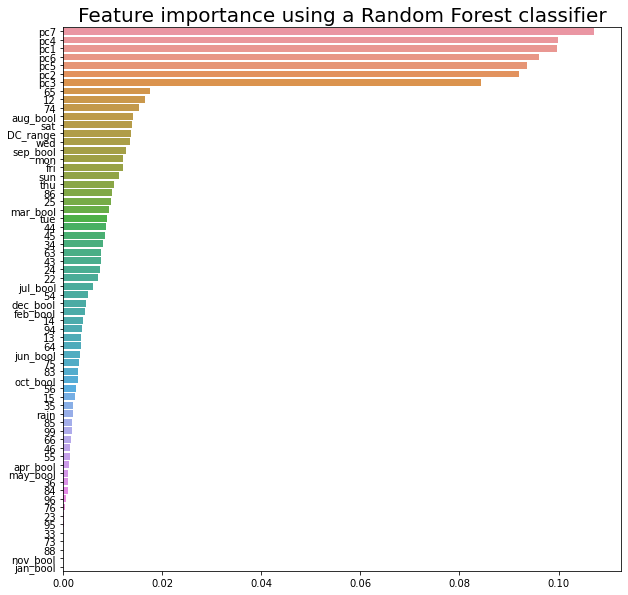

In [278]:
plt.figure(figsize=(10, 10))
g = sns.barplot(y=imp_series.index, x=imp_series, orient="h")
g.set_title("Feature importance using a Random Forest classifier", fontsize=20)
plt.show()

A lot of features have low importance, it's possible that the model is overfitting based on the features of low importance, so the features of low importance will be greedily removed

In [13]:
accuracies_mf = greedy_feature_removal(X_train, y_train, X_test, y_test)

There's some improvement but it's not big

## Using the dataset with less features

In [14]:
fires2 = pd.read_csv("fire_data_processed_after_pca2.csv")
y2 = fires2.loc[:,"area_bool"]
drop_cols = ['Unnamed: 0', 'area_bool']
X2 = fires2.drop(drop_cols, axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33, random_state=3558)
X_test_with_area2 = X_test2.copy()
X_test2 = X_test2.drop("area", axis=1)
X_with_area2 = X2.copy()
X2 = X2.drop("area", axis=1)
X_train_with_area2 = X_train2.copy()
X_train2 = X_train2.drop("area", axis=1)

In [15]:
rfc2 = RandomForestClassifier()
rfc2.fit(X_train2, y_train2)
y_pred2 = rfc2.predict(X_test2)
sum(y_pred2 == y_test2)/len(y_pred2)

0.6023391812865497

In [16]:
accuracies_lf = greedy_feature_removal(X_train2, y_train2, X_test2, y_test2)

In [17]:
max(accuracies_mf)

0.6081871345029239

In [18]:
max(accuracies_lf)

0.6081871345029239

There doesn't seem to be a huge difference, probably the method used for evaluation is pessimistic and doesn't reflect the behaviour of the model, let's change to other evaluation method.
Random forest are ensemble methods performing a process that resembles K-fold cross validation, and present a evaluation score called out of bag accuracy, that I'm going to use while using the whole dataset

In [19]:
gfr_low_feature_number = greedy_feature_removal_oob(X2, y)
gfr_high_feature_number =greedy_feature_removal_oob(X, y)

In [20]:
max(gfr_low_feature_number.values())

0.5813953488372093

In [21]:
max(gfr_high_feature_number.values())

0.5852713178294574

In [22]:
gfr_low_feature_number, gfr_high_feature_number = average_oob(X, X2, y)

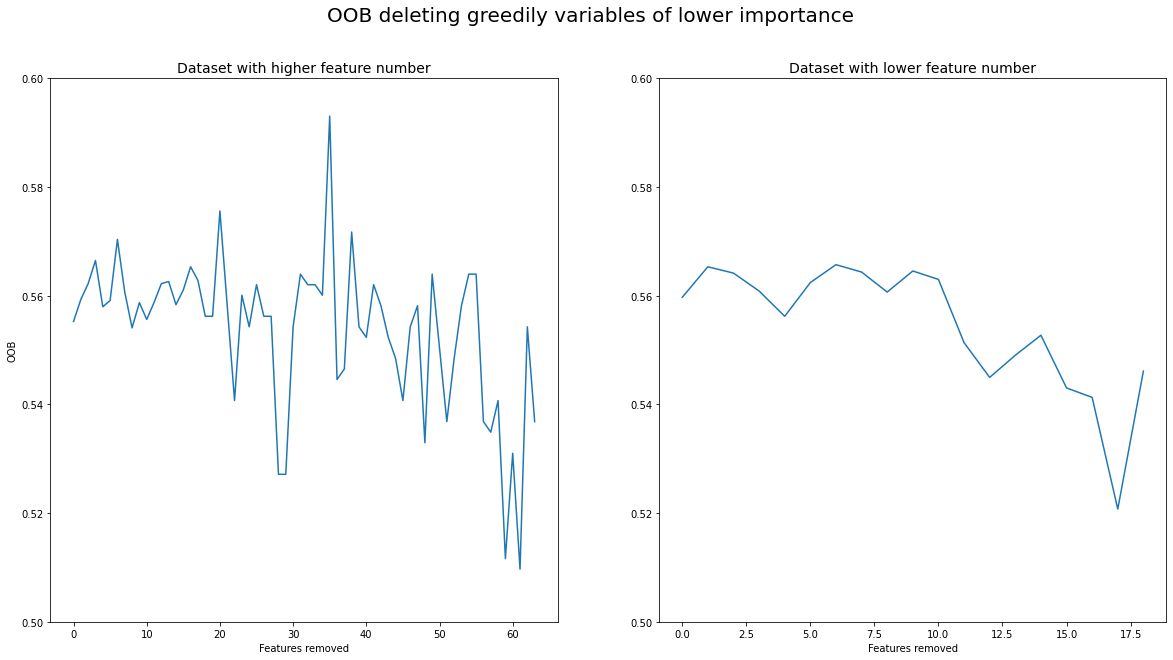

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
pd.Series(gfr_high_feature_number).plot(ax=axes[0])
axes[0].set_ylim([0.5, 0.6])
fig.suptitle("Evaluation metrics for different hyperparameters values for the dataset from january to may")
axes[0].set_title("Dataset with higher feature number", fontsize=14)
axes[0].set_xlabel("Features removed")
axes[0].set_ylabel("OOB")
axes[1].set_xlabel("Features removed")
axes[1].set_title("Dataset with lower feature number", fontsize=14)
axes[1].set_ylim([0.5, 0.6])
pd.Series(gfr_low_feature_number).plot(ax=axes[1])
fig.suptitle("OOB deleting greedily variables of lower importance", fontsize=20)
plt.show()

Using oob we reach the same ressult. The performance it's not radically different. And there's no easy way to classify the fires between 0 and non-zero. Two observations:

- There are a lot of fires with burnt area close to 0, if the fires predicted as 0 are almost 0, it shouldn't be very problematic.
- Maybe there are some instances easier to classify as 0, predicting those as 0 should be bennefitial for the model.

This leads to two possible strategies: 

- Try to find a model where missclassification is weighted differentially depending on the area of the missclassified instance.
- Try to find a model where false negatives have a much higher weight. 

In [24]:
most_important_features = imp_series[0:-25].index

In [25]:
rfc = RandomForestClassifier()
rfc.fit(X_train[most_important_features], y_train)
y_pred = rfc.predict(X_test[most_important_features])

In [26]:
false_negatives = (y_pred == 0) & (y_test == 1)

In [27]:
np.exp(X_test_with_area.loc[false_negatives]["area"])

483      27.43
223      38.71
196      12.06
361       1.52
295       1.90
161       2.94
209      25.23
329       7.58
212      28.35
262       2.56
479       3.75
137       1.36
508       3.17
423       5.96
145       1.95
229      89.49
187       8.40
492      44.32
365       2.75
467       7.61
237    1091.84
178       6.23
407       8.80
234     197.48
457       4.32
210      27.00
477       3.21
498      11.82
236     213.88
345      29.19
Name: area, dtype: float64

False negatives have high burnt areas too.
Trying to preclassify the data didn't work. 
There are several clues that suggest that the data could have two different generative patterns, like for example:

- Different types of vegetation on the area, that could change over time.
- If the fire was unintentional or not
- Different effects of the weather depending on the time of year.

### Exploring data clusters

In [28]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering()
clustering.fit(X2)

AgglomerativeClustering()

In [29]:
X2_c1 = X2[clustering.labels_ == 0]
X2_c2 = X2[clustering.labels_ == 1]
months = ['apr_bool', 'aug_bool', 'dec_bool', 'feb_bool','jan_bool', 'jul_bool', 'jun_bool', 'mar_bool', 'may_bool', 'nov_bool','oct_bool', 'sep_bool']

In [30]:
fires[clustering.labels_ == 0][months].describe().head(3)

,apr_bool,aug_bool,dec_bool,feb_bool,jan_bool,jul_bool,jun_bool,mar_bool,may_bool,nov_bool,oct_bool,sep_bool
count,430.0,430.000000,430.000000,430.0,430.0,430.000000,430.000000,430.0,430.000000,430.000000,430.000000,430.000000
mean,0.0,0.427907,0.020930,0.0,0.0,0.074419,0.037209,0.0,0.002326,0.002326,0.034884,0.400000
std,0.0,0.495352,0.143318,0.0,0.0,0.262757,0.189495,0.0,0.048224,0.048224,0.183699,0.490469


In [31]:
fires[clustering.labels_ == 1][months].describe().head(3)

,apr_bool,aug_bool,dec_bool,feb_bool,jan_bool,jul_bool,jun_bool,mar_bool,may_bool,nov_bool,oct_bool,sep_bool
count,86.000000,86.0,86.0,86.000000,86.000000,86.0,86.0,86.000000,86.000000,86.0,86.0,86.0
mean,0.104651,0.0,0.0,0.232558,0.023256,0.0,0.0,0.627907,0.011628,0.0,0.0,0.0
std,0.307899,0.0,0.0,0.424941,0.151599,0.0,0.0,0.486198,0.107833,0.0,0.0,0.0


The clustering seems to split the data by months almost perfectly: All entries in January, february, March and April are in one cluster, and may has elements in both clusters. May has most entries in one of the clusters, so the data and modelling will be done indepently for months 1-5, and 6-12

In [165]:
clustering = AgglomerativeClustering()
clustering.fit(X2_c1)

AgglomerativeClustering()

In [166]:
X2_c1[clustering.labels_ == 0].loc[:,["X", "Y"]].value_counts()

X  Y
3  4    33
4  4    29
2  4    25
4  3    20
2  2    20
   5    20
1  2    19
5  4    18
4  5    18
1  4    15
   3     9
4  6     5
3  6     4
   5     4
1  5     4
5  6     2
6  5     2
3  3     1
2  3     1
5  5     1
6  3     1
8  6     1
dtype: int64

In [163]:
X2_c1[clustering.labels_ == 1].loc[:,["X", "Y"]].value_counts()

X  Y
8  6    47
7  4    39
6  5    32
   3    19
7  5     9
6  4     5
9  9     4
   4     4
8  5     4
   3     3
6  6     3
7  6     2
9  5     2
8  4     1
7  3     1
8  8     1
9  6     1
5  6     1
dtype: int64

Apparently there could be a second split on the data depending on the x value, first the split by month will be tested

## With splitted model:

In [280]:
fires_jan = pd.read_csv("fires_jan_may.csv")

### First halfth (january to may): Binary classification

In [281]:
drop_cols = ['Unnamed: 0', 'area_bool']
X_jan = fires_jan.drop(drop_cols, axis=1)
y_jan = fires_jan.loc[:,"area_bool"]
X_train_jan, X_test_jan, y_train_jan, y_test_jan = train_test_split(X_jan, y_jan, test_size=0.33, random_state=3558)
X_test_with_area_jan = X_test_jan.copy()
X_test_jan = X_test_jan.drop("area", axis=1)
X_with_area_jan = X_jan.copy()
X_jan = X_jan.drop("area", axis=1)
X_train_with_area_jan = X_train.copy()
X_train_jan = X_train_jan.drop("area", axis=1)

In [282]:
rfc_temp_jan = SVC(class_weight={0:1, 1:1})
rfc_temp_jan.fit(X_train_jan, y_train_jan)
y_pred_jan = rfc_temp_jan.predict(X_test_jan)
accuracy_score(y_pred_jan, y_test_jan)

0.5517241379310345

In [283]:
false_negatives = (y_pred_jan == 0) & (y_test_jan == 1)

In [284]:
np.exp(X_test_with_area_jan.loc[false_negatives]["area"])

44     7.38
53    28.35
57    37.85
43     5.61
76     4.35
38     1.95
82     6.55
49    11.93
86    39.48
71    52.78
Name: area, dtype: float64

In [37]:
dropped_variables = np.arange(0, 20, 1)
gammas = np.linspace(1, 10, 10)
cs = np.linspace(0, 1000, 20)


In [68]:
areas_burnt_kernels_jan, test_accuracies_kernels_jan = select_kernel_kcross(X_jan, X_with_area_jan, y_jan)

linear
rbf
poly


In [70]:
areas_burnt_gammas_jan, test_accuracies_gammas_jan = select_gamma_kcross(X_jan, X_with_area_jan, y_jan, -10, 3)

In [86]:
areas_burnt_gammas_refinement_jan, test_accuracies_gammas_refinement_jan = select_gamma_kcross(X_jan, X_with_area_jan, y_jan, -1, 1)

In [97]:
areas_burnt_c_jan, test_accuracies_c_jan = select_c_kcross(X_jan, X_with_area_jan, y_jan, gamma=0.3727)

In [100]:
areas_burnt_c_refinement_jan, test_accuracies_c_refinement_jan = select_c_kcross_refinement(X_jan, X_with_area_jan, y_jan, min_c=2, max_c=20)

In [101]:
series_abg_jan = pd.Series(areas_burnt_gammas_jan)
series_abgr_jan = pd.Series(areas_burnt_gammas_refinement_jan)
series_abc_jan = pd.Series(areas_burnt_c_jan)
series_abcr_jan = pd.Series(areas_burnt_c_refinement_jan)
series_ag_jan = pd.Series(test_accuracies_gammas_jan)
series_agr_jan = pd.Series(test_accuracies_gammas_refinement_jan)
series_ac_jan = pd.Series(test_accuracies_c_jan)
series_acr_jan = pd.Series(test_accuracies_c_refinement_jan)

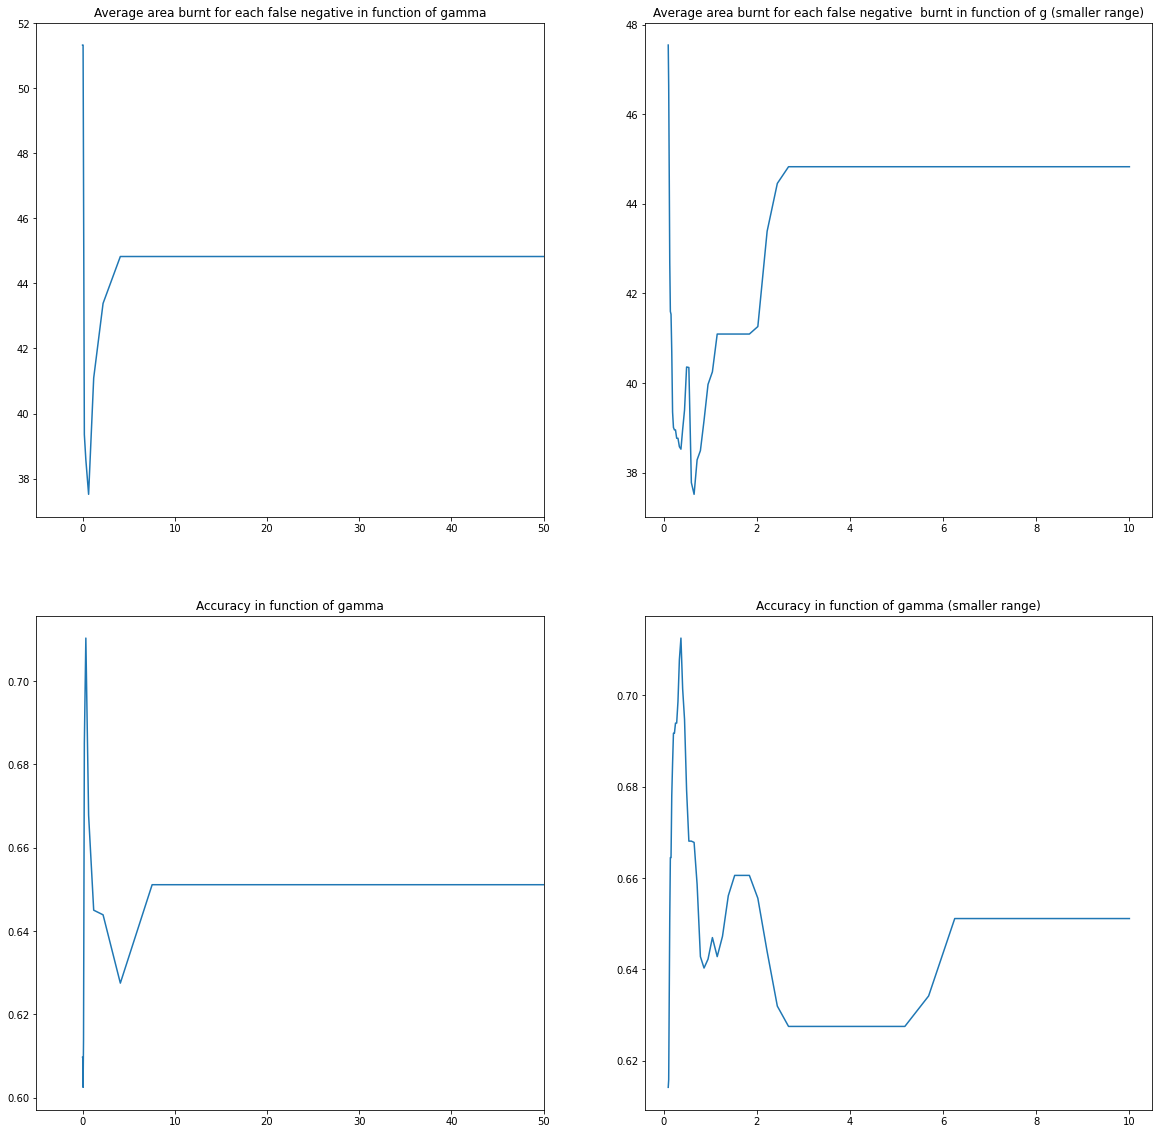

In [98]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
g1 = series_abg_jan.plot(ax=axes[0][0])
g1.set_title("Average area burnt for each false negative in function of gamma")
#g1.set_ylim([0, 20])
g1.set_xlim([-5, 50])
g2 = series_abgr_jan.plot(ax=axes[0][1])
g2.set_title("Average area burnt for each false negative  burnt in function of g (smaller range)")
#g2.set_ylim([0,20])
g3 = series_ag_jan.plot(ax=axes[1][0])
g3.set_xlim([-5, 50])
g3.set_title("Accuracy in function of gamma")
g4 = series_agr_jan.plot(ax=axes[1][1])
g4.set_title("Accuracy in function of gamma (smaller range)")
plt.show()

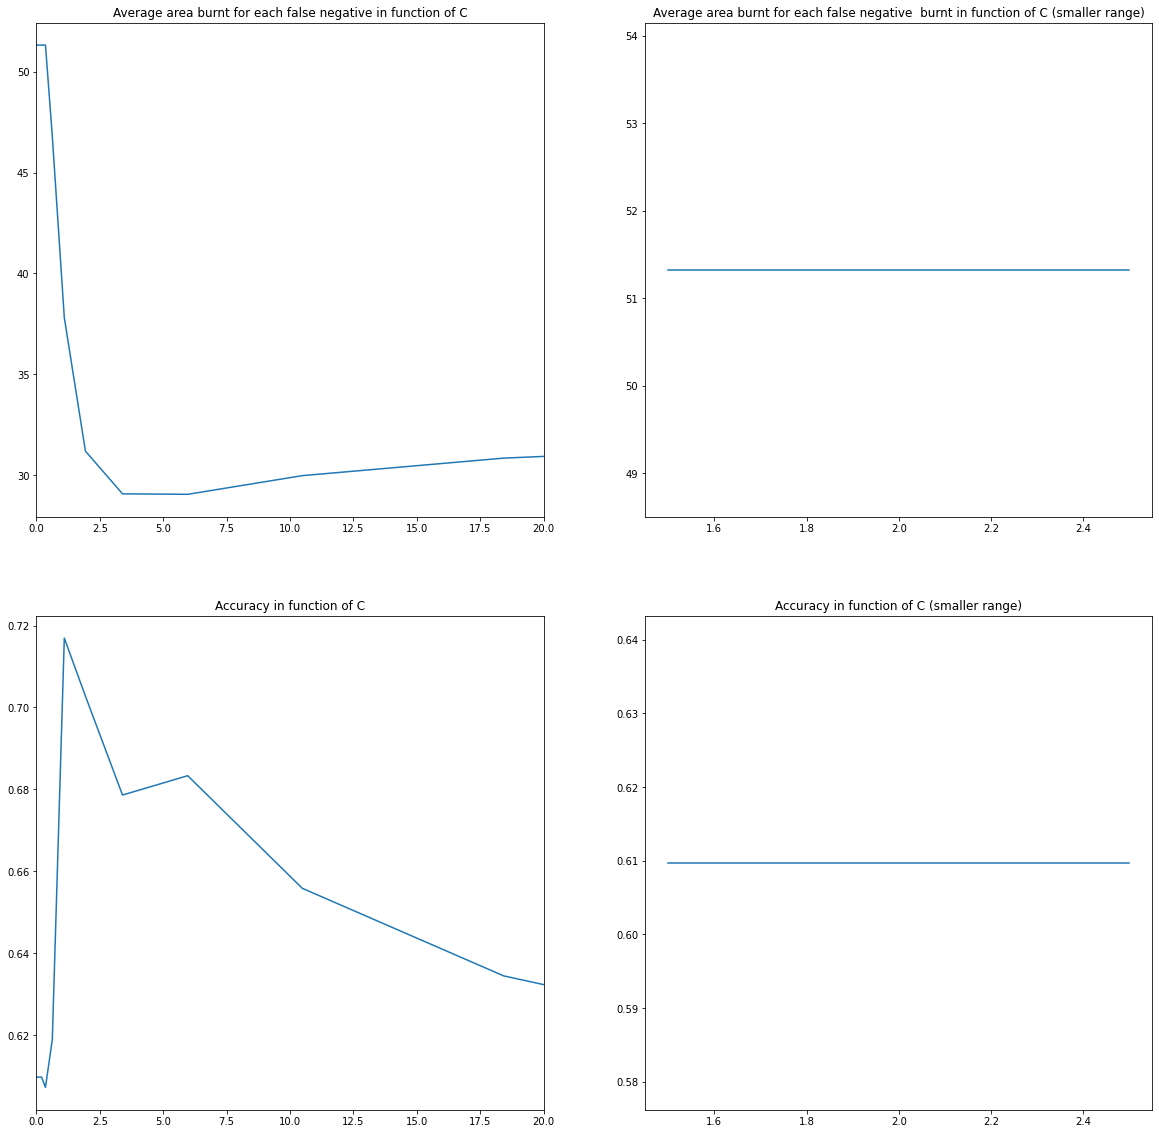

In [105]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
g1 = series_abc_jan.plot(ax=axes[0][0])
g1.set_title("Average area burnt for each false negative in function of C")
#g1.set_ylim([0, 20])
g1.set_xlim([0, 20])
g2 = series_abcr_jan.plot(ax=axes[0][1])
g2.set_title("Average area burnt for each false negative  burnt in function of C (smaller range)")
#g2.set_ylim([0,20])
g3 = series_ac_jan.plot(ax=axes[1][0])
g3.set_xlim([0, 20])
g3.set_title("Accuracy in function of C")
g4 = series_acr_jan.plot(ax=axes[1][1])
g4.set_title("Accuracy in function of C (smaller range)")
plt.show()

In [285]:
rfc = SVC(kernel = 'rbf', gamma=0.3727, C= 3)
rfc.fit(X_jan, y_jan)
y_pred = rfc.predict(X_test_jan)
area_burnt(X_test_with_area_jan, y_pred, y_test_jan)

6.549999999999999

In [286]:
accuracy_score(y_pred, y_test_jan)

0.9310344827586207

Even with a lower accuracy score, there seems to be a local maxima of accuracy and a global minima of false negatives at this point of the model space. Exactly this model seems a perfect option for our preclassification task

In [287]:
with open("classification_jan_may.pickle", 'wb') as f:
    pickle.dump(rfc, f)

alternative model, maximizing accuracy using scikit-optimize

*(note: The accuracy was maximized using stratified cross validation, here the score is calculated only in a subset of test data, which can yield wrong estimations)*

In [288]:
rfc = SVC(C = 36.016330496165466, kernel = 'rbf', gamma= 0.008066428945580253)
rfc.fit(X_jan, y_jan)
y_pred = rfc.predict(X_test_jan)
area_burnt(X_test_with_area_jan, y_pred, y_test_jan)

59.32999999999999

In [289]:
accuracy_score(y_pred, y_test_jan)

0.7931034482758621

In [290]:
with open("classification_jan_may_skopt.pickle", 'wb') as f:
    pickle.dump(rfc, f)